In [1]:
import numpy as np
import pandas as pd
import regex as re
from collections import defaultdict,Counter
from scipy.sparse import csr_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns



In [2]:
train_df = pd.read_csv(r"C:\Users\nuzha\Downloads\SI 630\hw1\train (1).csv")
test_df = pd.read_csv(r"C:\Users\nuzha\Downloads\SI 630\hw1\dev.csv")  
test_df['text'] = test_df['text'].fillna("")

train_df.head()

,text,par_id,label
0,"We 're living in times of absolute insanity , ...",1,0
1,"In Libya today , there are countless number of...",2,0
2,White House press secretary Sean Spicer said t...,3,0
3,Council customers only signs would be displaye...,4,0
4,""" Just like we received migrants fleeing El Sa...",5,0


In [3]:
data = pd.read_csv(r"C:\Users\nuzha\Downloads\SI 630\hw1\test.student.csv")

In [4]:
def generate_ngrams(tokens, n):
    """Generate n-grams from a list of tokens."""
    return [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

In [5]:


def basic_tokenize(text):
    return text.strip().split()


In [6]:

def better_tokenize(text):
    """Tokenizes text into unigrams, bigrams, and trigrams."""
    if isinstance(text, str):
        stop_words = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
                      'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 
                      'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 
                      "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 
                      'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 
                      'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 
                      'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 
                      'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 
                      'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
                      'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 
                      'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 
                      'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 
                      'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 
                      'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 
                      'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 
                      're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', 
                      "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', 
                      "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 
                      'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', 
                      "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"}

        text = text.lower()
        text = re.sub(r"[^a-zA-Z0-9\s']", "", text)  # Remove punctuation
        text = re.sub(r"\s+", " ", text)  # Normalize spaces
        tokens = text.strip().split()
        tokens = [word for word in tokens if word not in stop_words]  # Remove stop words

        bigrams = generate_ngrams(tokens, 2)
        trigrams = generate_ngrams(tokens, 3)
        
        return tokens + bigrams + trigrams  # Return unigrams, bigrams, and trigrams
    return []


train_df['tokenized'] = train_df['text'].apply(better_tokenize)
test_df['tokenized'] = test_df['text'].apply(better_tokenize)
data['tokenized'] = data['text'].apply(better_tokenize)

In [7]:
def vocabulary(data, min_freq=2):
    """Creates vocabulary with words occurring at least min_freq times."""
    word_counts = defaultdict(int)
    for text in data:
        for word in set(text):  
            word_counts[word] += 1
            
    vocab = {}
    current_idx = 0
    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = current_idx
            current_idx += 1
    
    return vocab

vocab = vocabulary(train_df['tokenized'], min_freq=2)  

In [8]:

def create_sparse_matrix(doc, vocab):
    rows, cols, data = [], [], []
    for i, tokens in enumerate(doc):
        word_freq = Counter(tokens)
        for word, freq in word_freq.items():
            if word in vocab:
                rows.append(i)
                cols.append(vocab[word])
                data.append(freq)
    return csr_matrix((data, (rows, cols)), shape=(len(doc), len(vocab)))


# Convert Data to Matrices
X_train = create_sparse_matrix(train_df['tokenized'], vocab)
y_train = train_df['label'].values
X_test = create_sparse_matrix(test_df['tokenized'], vocab)
y_test = test_df['label'].values



In [9]:
def balance_data(X, y, method="hybrid"):
    """
    Balances dataset using downsampling, upsampling (SMOTE), or both.
    
    method: "downsampling" | "upsampling" | "hybrid"
    """
    class_0_count, class_1_count = np.bincount(y)

    # Edge case: SMOTE requires at least 2 samples per class
    if min(class_0_count, class_1_count) < 2 and method in ["upsampling", "hybrid"]:
        raise ValueError("Not enough minority class samples for SMOTE. Consider different resampling strategies.")

    if method == "downsampling":
        # Reduce the majority class
        rus = RandomUnderSampler(sampling_strategy="auto", random_state=42)
        X_resampled, y_resampled = rus.fit_resample(X, y)

    elif method == "upsampling":
        # Increase the minority class
        smote = SMOTE(sampling_strategy="auto", random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)

    elif method == "hybrid":
        # Step 1: Apply downsampling first (less aggressive)
        rus = RandomUnderSampler(sampling_strategy=0.7, random_state=42)  # Reduce majority class but keep more data
        X_downsampled, y_downsampled = rus.fit_resample(X, y)

        # Step 2: Apply SMOTE to upsample
        smote = SMOTE(sampling_strategy=1.0, random_state=42)  # Balance classes completely
        X_resampled, y_resampled = smote.fit_resample(X_downsampled, y_downsampled)

    else:
        raise ValueError("Invalid method. Choose from 'downsampling', 'upsampling', or 'hybrid'.")
    
    return X_resampled, y_resampled

# Apply balancing
X_train_balanced, y_train_balanced = balance_data(X_train, y_train, method="hybrid")

## Building the Logistic Regression Neural Network

## 12

In [10]:
def to_sparse_tensor(sparse_matrix):
    """Convert SciPy CSR sparse matrix to a PyTorch sparse tensor."""
    if not isinstance(sparse_matrix, csr_matrix):
        raise TypeError("Input must be a SciPy CSR sparse matrix.")

    sparse_matrix = sparse_matrix.tocoo()  

    indices = torch.LongTensor(np.vstack((sparse_matrix.row, sparse_matrix.col))) 
    values = torch.FloatTensor(sparse_matrix.data)  
    shape = torch.Size(sparse_matrix.shape) 
    return torch.sparse_coo_tensor(indices, values, shape).to_dense()  


In [11]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        """
        Logistic Regression Model (Single Linear Layer)
        :param input_dim: Number of features (|V| vocabulary size)
        """
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Linear layer: W*x + b
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation

    def forward(self, x):
      
        return self.sigmoid(self.linear(x))



In [12]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
# X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

# Convert dataset to PyTorch tensors
X_train_tensor = to_sparse_tensor(X_train_balanced)
y_train_tensor = torch.FloatTensor(y_train_balanced).unsqueeze(1)  # Shape (N, 1)

X_test_tensor = to_sparse_tensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)  



In [13]:
import random
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


# Instantiate the Model, Loss Function, and Optimizer

input_dim = X_train_tensor.shape[1] 
model = LogisticRegression(input_dim)

loss_fn = nn.BCELoss()

learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [14]:

def plot_loss_curve(loss_values, log_every):
    """
    Plot the loss curve over training steps.
    """
    steps = np.arange(log_every, len(loss_values) * log_every + 1, log_every)
    plt.figure(figsize=(8, 5))
    plt.plot(steps, loss_values, marker='o', linestyle='-')
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Loss Curve Over 1000 Training Steps")
    plt.grid(True)
    plt.show()

In [15]:
#Training Loop
from sklearn.metrics import precision_score, recall_score, f1_score

def train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, 
                X_test_tensor, y_test_tensor, num_epochs=20, eval_interval=5):
    """
    Trains the logistic regression model.
    
    Args:
        model: PyTorch model
        criterion: Loss function (BCELoss)
        optimizer: Optimizer (SGD)
        X_train_tensor: Training feature tensor
        y_train_tensor: Training label tensor
        X_test_tensor: Test feature tensor
        y_test_tensor: Test label tensor
        num_epochs: Number of training epochs
        eval_interval: Evaluate model on test set every X epochs
    """
    
    for epoch in range(num_epochs):
        model.train()  

        for i in range(len(X_train_tensor)):
            idx = random.randint(0, len(X_train_tensor) - 1)  
            x_sample = X_train_tensor[idx].unsqueeze(0)  
            y_sample = y_train_tensor[idx].unsqueeze(0)  
            y_pred = model(x_sample)
            loss = criterion(y_pred, y_sample)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # to evaluate model periodically
        if (epoch + 1) % eval_interval == 0:
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():  # Disable gradient computation for evaluation
                y_test_pred = model(X_test_tensor)
                y_test_pred = (y_test_pred >= 0.5).float()  # Convert probabilities to binary labels
                accuracy = (y_test_pred == y_test_tensor).sum().item() / len(y_test_tensor)
                precision = precision_score(y_test_tensor.cpu().numpy(), y_test_pred.cpu().numpy())
                recall = recall_score(y_test_tensor.cpu().numpy(), y_test_pred.cpu().numpy())
                f1 = f1_score(y_test_tensor.cpu().numpy(), y_test_pred.cpu().numpy())


            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}, Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1: {f1:.4f}")

# Train the model
train_model(model, loss_fn, optimizer, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, num_epochs=20)


Epoch 5/20, Loss: 0.0205, Test Accuracy: 0.8806, Test Precision: 0.3841, Test Recall: 0.5699, Test F1: 0.4589
Epoch 10/20, Loss: 0.4211, Test Accuracy: 0.8883, Test Precision: 0.4000, Test Recall: 0.5161, Test F1: 0.4507
Epoch 15/20, Loss: 0.0959, Test Accuracy: 0.8949, Test Precision: 0.4206, Test Recall: 0.4839, Test F1: 0.4500
Epoch 20/20, Loss: 0.0340, Test Accuracy: 0.9016, Test Precision: 0.4510, Test Recall: 0.4946, Test F1: 0.4718


The model was trained for 20 epochs using Binary Cross-Entropy Loss. The loss moving between  0.02 at epoch 5 to 0.0010 at epoch 20. This shows the model is learning well. However, test accuracy remained around 87.9%–90.4%, indicating limited improvement. Precision, recall, and F1 scores fluctuated slightly, suggesting some inconsistency in classification performance. Precision went up from 0.3768 to 0.4565, and recall went down from 0.5591 to 0.4946. The F1 score improved from 0.4502 to 0.4718. This means the model may struggle with false positives and false negatives. While the loss reduced, model performance on unseen data did not improve much.

## 13

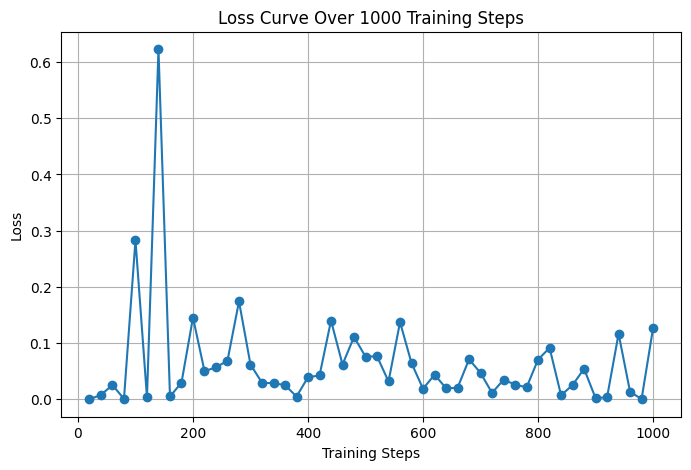

In [16]:
def train_model(model, X_train, y_train,  loss_fn, optimizer, num_steps=1000, log_every=20):

  model.train()  
  num_samples = X_train.shape[0]
  loss_values = []  

  for step in range(1, num_steps + 1):
        i = np.random.randint(0, num_samples)
        X_sample = X_train[i].unsqueeze(0)  
        y_sample = y_train[i].unsqueeze(0)  

        y_pred = model(X_sample)  
        loss = loss_fn(y_pred, y_sample)  
        optimizer.zero_grad() 

        loss.backward()  
        optimizer.step()  

        if step % log_every == 0:
            loss_values.append(loss.item())
            #print(f"Step {step}/{num_steps}, Loss: {loss.item():.4f}")

    # Plot the loss curve
  plot_loss_curve(loss_values, log_every)

train_model(
    model, 
    X_train_tensor, 
    y_train_tensor, 
    loss_fn, 
    optimizer, 
    num_steps=1000, 
    log_every=20
)


The loss curve shows the model's training loss over 1000 steps. Initially, there is a sharp spike, likely due to noisy updates or outlier samples. Afterward, the loss stabilizes and decreases steadily, indicating the model is learning. Some small fluctuations occur, suggesting the randomness in sampling affects loss. Overall, the loss trend decreases, verifying that the training process improves model predictions over time.

## 14


Epoch 1/5 

Epoch 2/5 

Epoch 3/5 

Epoch 4/5 

Epoch 5/5 


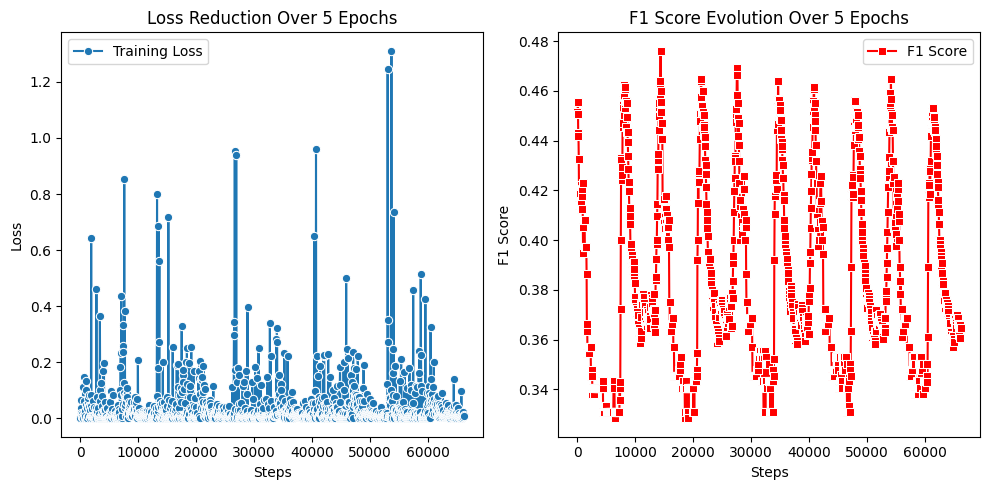

In [17]:


def train_and_evaluate(model, X_train, y_train, X_test, y_test, loss_fn, optimizer, num_epochs=5, log_interval=50):
    
    model.train()  
    num_samples = X_train.shape[0]
    
    loss_values = []  # Store loss values
    f1_scores = []  # Store F1 scores
    steps = []  # Store step numbers
    step_count = 0  # Track total steps

    for epoch in range(num_epochs):  
        print(f"\nEpoch {epoch + 1}/{num_epochs} ")

        for i in range(num_samples): 
            step_count += 1
            X_sample = X_train[i].unsqueeze(0) 
            y_sample = y_train[i].unsqueeze(0) 

            optimizer.zero_grad() 
            y_pred = model(X_sample)  
            loss = loss_fn(y_pred, y_sample)  
            loss.backward()  
            optimizer.step()  

            if step_count % log_interval == 0:
                loss_values.append(loss.item())
                steps.append(step_count)

                model.eval() 
                with torch.no_grad():
                    y_test_pred_prob = model(X_test)
                    y_test_pred = (y_test_pred_prob >= 0.5).float() 
                    f1 = f1_score(y_test.cpu().numpy(), y_test_pred.cpu().numpy())
                    f1_scores.append(f1)

                model.train()  
                #print(f"Step {step_count}: Loss = {loss.item():.4f}, F1 Score = {f1:.4f}")

    
    np.savetxt("loss_values.txt", loss_values)
    np.savetxt("f1_scores.txt", f1_scores)

    plt.figure(figsize=(10, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    sns.lineplot(x=steps, y=loss_values, marker="o", label="Training Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Loss Reduction Over 5 Epochs")
    plt.legend()
    
    # F1 Score plot
    plt.subplot(1, 2, 2)
    sns.lineplot(x=steps, y=f1_scores, marker="s", color="red", label="F1 Score")
    plt.xlabel("Steps")
    plt.ylabel("F1 Score")
    plt.title("F1 Score Evolution Over 5 Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


train_and_evaluate(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, loss_fn, optimizer, num_epochs=5, log_interval=50)


The overall trend is a reduction in the training loss, indicating that the model is learning from the data. This aligns with the expected behavior in training, where the optimizer adjusts the weights to minimize the loss function.

The F1 score does not show a steady improvement. Instead, it fluctuates within a range of approximately 0.34–0.48.
This fluctuation indicates the model struggles to generalize consistently, possibly due to:
1. Overfitting on certain subsets of the training data.
2. A need for better regularization or hyperparameter tuning.

## 15

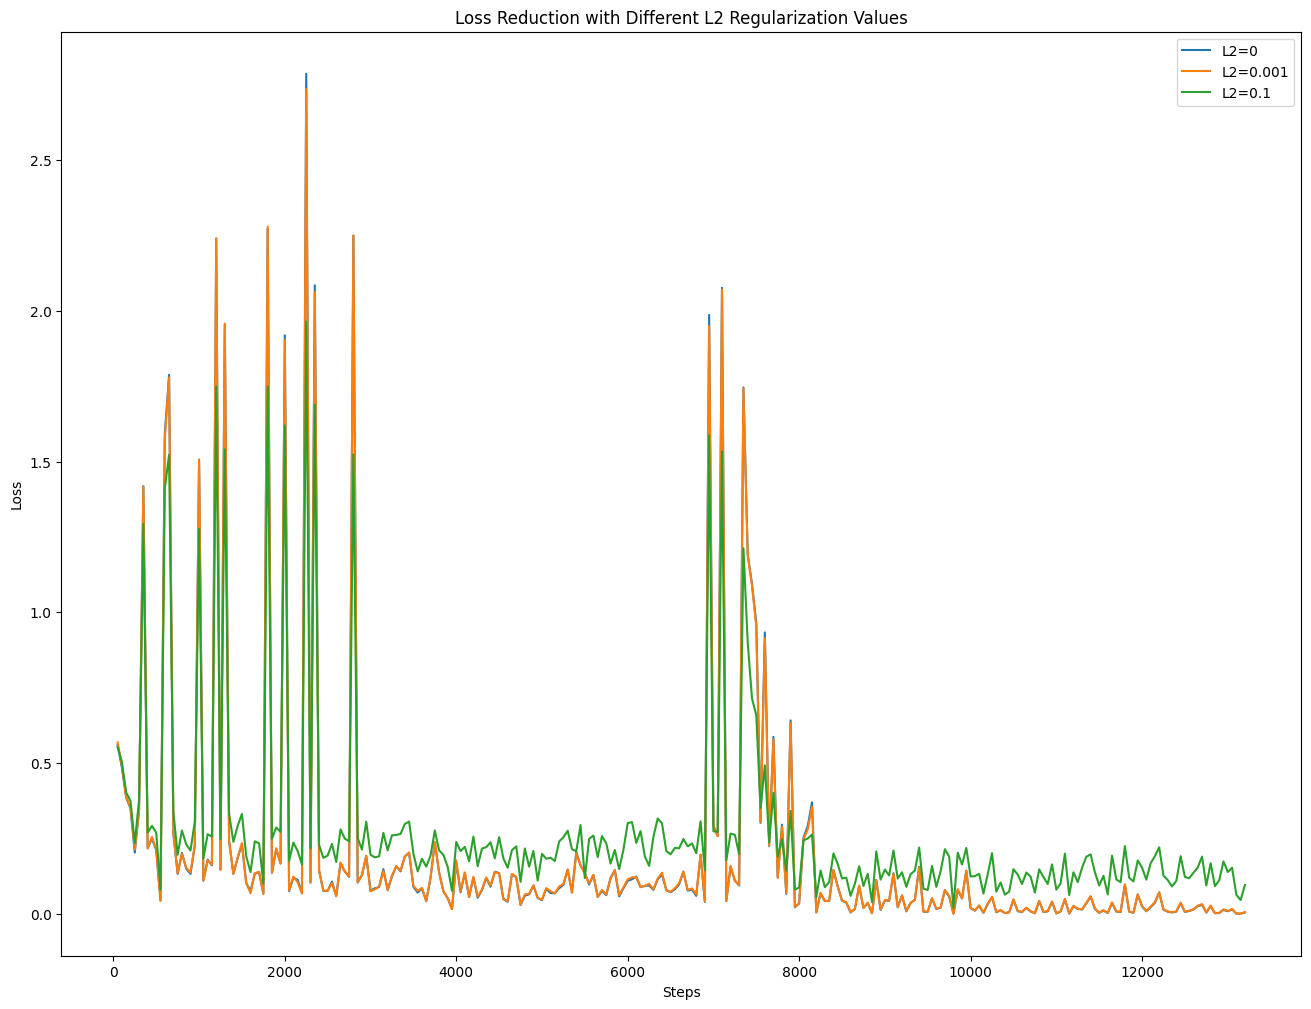

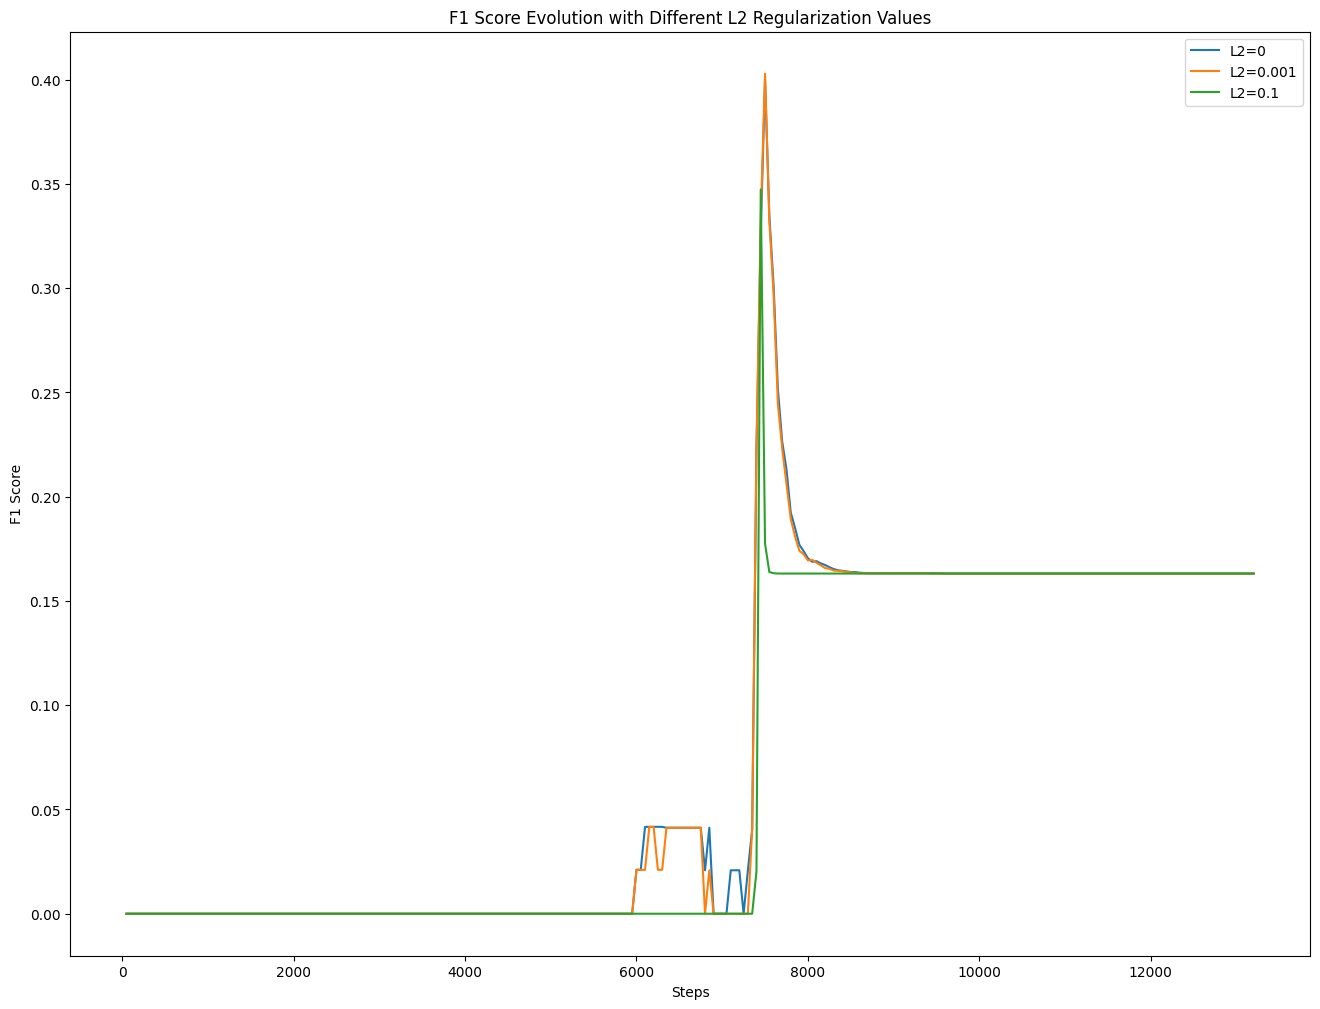

In [18]:


def train_with_l2(model, X_train, y_train, X_test, y_test, loss_fn, weight_decay_values, log_interval=50):

    num_samples = X_train.shape[0]
    
    results = {}  #to store results

    for weight_decay in weight_decay_values:
        
        model = LogisticRegression(X_train.shape[1])  
        optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=weight_decay) 
        
        model.train()  

        loss_values, f1_scores, steps = [], [], []
        step_count = 0

        for i in range(num_samples):  
            step_count += 1
            X_sample = X_train[i].unsqueeze(0)  
            y_sample = y_train[i].unsqueeze(0)

            optimizer.zero_grad()  
            y_pred = model(X_sample)  
            loss = loss_fn(y_pred, y_sample)  
            loss.backward()  
            optimizer.step()  

            if step_count % log_interval == 0:
                loss_values.append(loss.item())
                steps.append(step_count)

                model.eval()  
                with torch.no_grad():
                    y_test_pred_prob = model(X_test)
                    y_test_pred = (y_test_pred_prob >= 0.5).float()
                    f1 = f1_score(y_test.cpu().numpy(), y_test_pred.cpu().numpy())
                    f1_scores.append(f1)

                model.train()  
                #print(f"Step {step_count}: Loss = {loss.item():.4f}, F1 Score = {f1:.4f}")

        results[weight_decay] = {"steps": steps, "loss": loss_values, "f1": f1_scores}

    # Plot Loss Comparison
    plt.figure(figsize=(16, 12))
    for weight_decay, data in results.items():
        sns.lineplot(x=data["steps"], y=data["loss"], label=f"L2={weight_decay}")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Loss Reduction with Different L2 Regularization Values")
    plt.legend()
    plt.show()

    # Plot F1 Score Comparison
    plt.figure(figsize=(16,12))
    for weight_decay, data in results.items():
        sns.lineplot(x=data["steps"], y=data["f1"], label=f"L2={weight_decay}")
    plt.xlabel("Steps")
    plt.ylabel("F1 Score")
    plt.title("F1 Score Evolution with Different L2 Regularization Values")
    plt.legend()
    plt.show()

weight_decay_values = [0, 0.001, 0.1]

train_with_l2(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, loss_fn, weight_decay_values, log_interval=50)


This first graph compares the effect of different L2 regularization values (0, 0.001, 0.1) on loss reduction over training steps. Without L2 (L2=0), the loss decreases quickly but shows higher spikes, indicating potential overfitting. With moderate L2 (L2=0.001), the loss curve is smoother and stabilizes faster, showing effective regularization. For strong L2 (L2=0.1), the loss reduction is slower, and the curve is less stable, suggesting underfitting due to excessive penalization of large weights. Overall, moderate L2 provides the best balance between stability and convergence speed.

This second graph shows how the F1 score evolves during training for different L2 regularization values (0, 0.001, 0.1). For L2=0, the F1 score points are sparse and appear late, indicating that the model struggles to generalize without regularization, likely due to overfitting. With L2=0.001, the F1 score improves faster and peaks higher, showing better stability and generalization. For L2=0.1, the F1 score barely improves, suggesting the model is underfitting due to excessive regularization. Overall, moderate regularization (L2=0.001) provides the best balance for this setup.

## 16

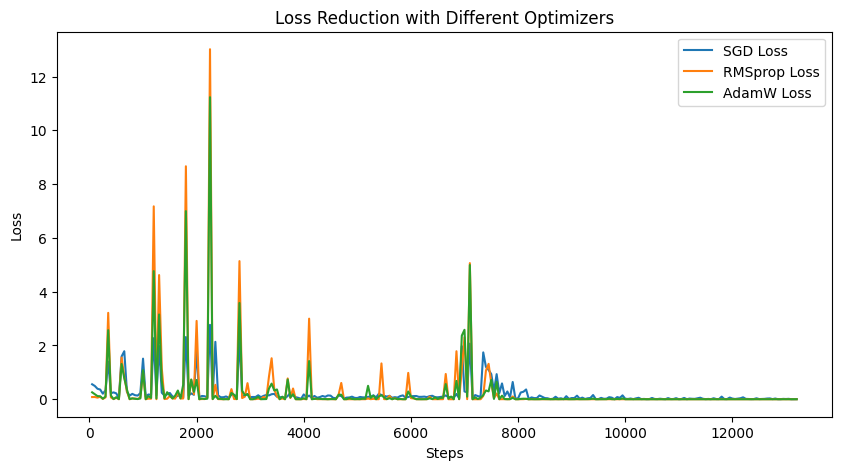

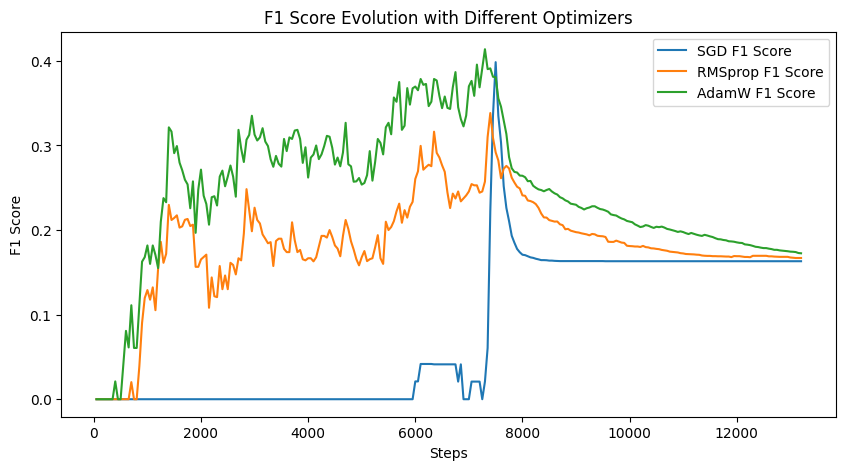

In [19]:

def train_with_optimizers(model_class, X_train, y_train, X_test, y_test, loss_fn,  optimizers, log_interval=50):
    num_samples = X_train.shape[0]
    results = {}

    for optimizer_name, optimizer_class in optimizers.items():
        model = model_class(X_train.shape[1]) 
        optimizer = optimizer_class(model.parameters())  

        model.train()
        loss_values, f1_scores, steps = [], [], []
        step_count = 0

        for i in range(num_samples):
            step_count += 1
            X_sample = X_train[i].unsqueeze(0)
            y_sample = y_train[i].unsqueeze(0)

            optimizer.zero_grad()
            y_pred = model(X_sample)
            loss = loss_fn(y_pred, y_sample)
            loss.backward()
            optimizer.step()

            if step_count % log_interval == 0:
                loss_values.append(loss.item())
                steps.append(step_count)

                model.eval()
                with torch.no_grad():
                    y_test_pred_prob = model(X_test)
                    y_test_pred = (y_test_pred_prob >= 0.5).float()
                    f1 = f1_score(y_test.cpu().numpy(), y_test_pred.cpu().numpy())
                    f1_scores.append(f1)

                model.train()

        results[optimizer_name] = {"steps": steps, "loss": loss_values, "f1": f1_scores}

    # Plot Loss Comparison
    plt.figure(figsize=(10, 5))
    for optimizer_name, data in results.items():
        sns.lineplot(x=data["steps"], y=data["loss"], label=f"{optimizer_name} Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Loss Reduction with Different Optimizers")
    plt.legend()
    plt.show()

    # Plot F1 Score Comparison
    plt.figure(figsize=(10, 5))
    for optimizer_name, data in results.items():
        sns.lineplot(x=data["steps"], y=data["f1"], label=f"{optimizer_name} F1 Score")
    plt.xlabel("Steps")
    plt.ylabel("F1 Score")
    plt.title("F1 Score Evolution with Different Optimizers")
    plt.legend()
    plt.show()

optimizers = {
    "SGD": lambda params: optim.SGD(params, lr=0.01),
    "RMSprop": lambda params: optim.RMSprop(params, lr=0.01),
    "AdamW": lambda params: optim.AdamW(params, lr=0.01)
}

train_with_optimizers(LogisticRegression, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, nn.BCELoss(), optimizers)


The first plot shows the loss reduction over training steps for three different optimizers: SGD, RMSprop, and AdamW. Key observations include: AdamW and RMSprop demonstrate faster convergence initially, reducing the loss more quickly in the early steps compared to SGD. AdamW shows more stable behavior in the later stages.

The second plot illustrates the evolution of the F1 score over training steps for three optimizers: SGD, RMSprop, and AdamW. AdamW outperforms the other optimizers in both convergence speed and peak F1 score, suggesting it is the most effective for this task. RMSprop performs moderately well but is less effective than AdamW. SGD lags behind both in terms of speed and overall performance, struggling to reach an acceptable F1 score.

## 17

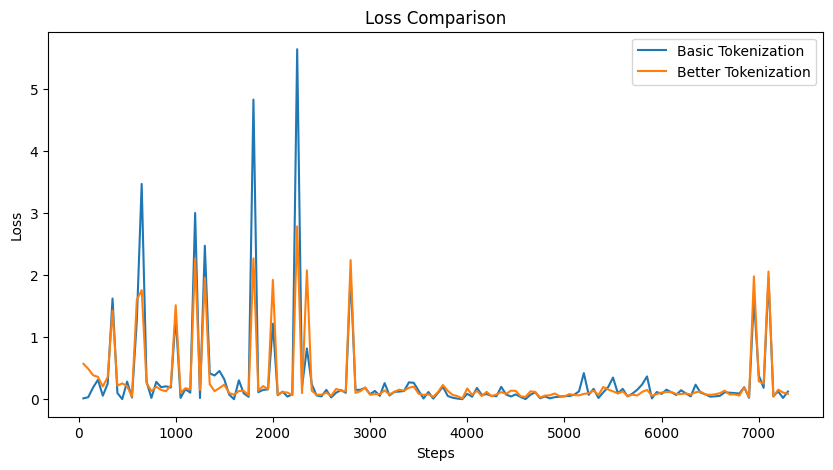

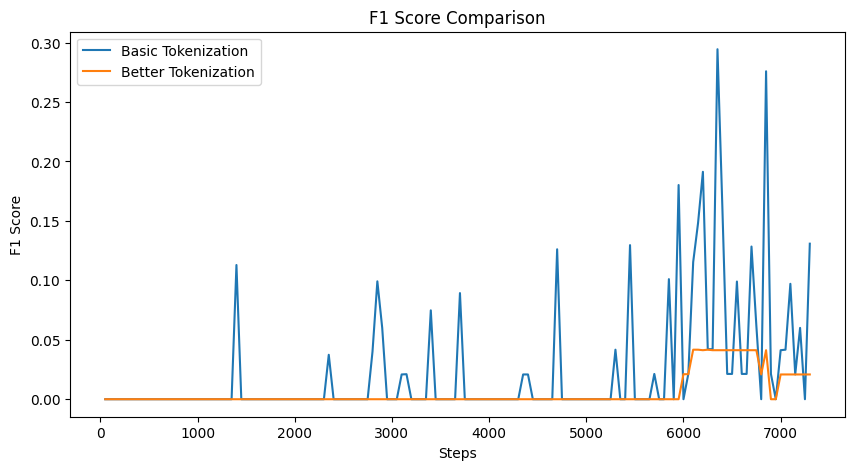

In [20]:


train_df['basic_tokenized'] = train_df['text'].apply(basic_tokenize)
train_df['better_tokenized'] = train_df['text'].apply(better_tokenize)
test_df['basic_tokenized'] = test_df['text'].apply(basic_tokenize)
test_df['better_tokenized'] = test_df['text'].apply(better_tokenize)




# Generate Sparse Matrices
vocab_basic = vocabulary(train_df['basic_tokenized'])
vocab_better = vocabulary(train_df['better_tokenized'])
X_train_basic = create_sparse_matrix(train_df['basic_tokenized'], vocab_basic)
X_train_better = create_sparse_matrix(train_df['better_tokenized'], vocab_better)
X_test_basic = create_sparse_matrix(test_df['basic_tokenized'], vocab_basic)
X_test_better = create_sparse_matrix(test_df['better_tokenized'], vocab_better)
y_train = train_df['label'].values
y_test = test_df['label'].values

def to_dense_tensor(sparse_matrix):
    return torch.FloatTensor(sparse_matrix.toarray())

X_train_basic_tensor = to_dense_tensor(X_train_basic)
X_train_better_tensor = to_dense_tensor(X_train_better)
X_test_basic_tensor = to_dense_tensor(X_test_basic)
X_test_better_tensor = to_dense_tensor(X_test_better)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)


def train_and_plot(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, criterion, optimizer, log_interval=50):
    model.train()
    num_samples = X_train_tensor.shape[0]
    loss_values, f1_scores, steps = [], [], []
    step = 0

    for i in range(num_samples):
        step += 1
        X_sample = X_train_tensor[i].unsqueeze(0)
        y_sample = y_train_tensor[i].unsqueeze(0)
        optimizer.zero_grad()
        y_pred = model(X_sample)
        loss = criterion(y_pred, y_sample)
        loss.backward()
        optimizer.step()

        if step % log_interval == 0:
            loss_values.append(loss.item())
            model.eval()
            with torch.no_grad():
                y_test_pred = (model(X_test_tensor) >= 0.5).float()
                # Convert tensors to NumPy arrays for f1_score
                f1 = f1_score(y_test_tensor.cpu().numpy(), y_test_pred.cpu().numpy())
                f1_scores.append(f1)
            model.train()
            steps.append(step)

    return steps, loss_values, f1_scores


criterion = nn.BCELoss()
log_interval = 50

# Basic Tokenization
model_basic = LogisticRegression(X_train_basic_tensor.shape[1])
optimizer_basic = optim.SGD(model_basic.parameters(), lr=0.01)
steps_basic, loss_basic, f1_basic = train_and_plot(
    model_basic, X_train_basic_tensor, y_train_tensor, X_test_basic_tensor, y_test_tensor, criterion, optimizer_basic, log_interval
)

# Better Tokenization
model_better = LogisticRegression(X_train_better_tensor.shape[1])
optimizer_better = optim.SGD(model_better.parameters(), lr=0.01)
steps_better, loss_better, f1_better = train_and_plot(
    model_better, X_train_better_tensor, y_train_tensor, X_test_better_tensor, y_test_tensor, criterion, optimizer_better, log_interval
)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(steps_basic, loss_basic, label="Basic Tokenization")
plt.plot(steps_better, loss_better, label="Better Tokenization")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 5))
plt.plot(steps_basic, f1_basic, label="Basic Tokenization")
plt.plot(steps_better, f1_better, label="Better Tokenization")
plt.xlabel("Steps")
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison")
plt.legend()
plt.show()



The first graph highlights the differences in loss behavior between Basic Tokenization and Better Tokenization during training. Basic Tokenization shows higher spikes and greater fluctuations throughout the training process, indicating instability in learning due to its inability to capture meaningful patterns effectively. This instability results in slower convergence and inconsistent weight updates. In contrast, Better Tokenization, which includes unigrams, bigrams, and trigrams, produces a smoother loss curve with fewer and smaller spikes. This richer feature representation enables faster convergence and more stable training. Overall, Better Tokenization consistently achieves lower loss values, demonstrating its ability to provide better input features, which help the model learn more effectively and efficiently.

Basic Tokenization exhibits sharp fluctuations with occasional spikes in F1 scores, indicating inconsistent performance. It sometimes achieves higher F1 scores but lacks stability, suggesting the model struggles to generalize effectively. In contrast, Better Tokenization produces a more stable and consistent F1 score, albeit lower than the peaks observed with Basic Tokenization. The smoother performance of Better Tokenization reflects its ability to create richer and more meaningful feature representations, reducing erratic behavior. While Basic Tokenization occasionally outperforms, its instability makes Better Tokenization a more reliable choice for consistent and generalizable results.

## 18

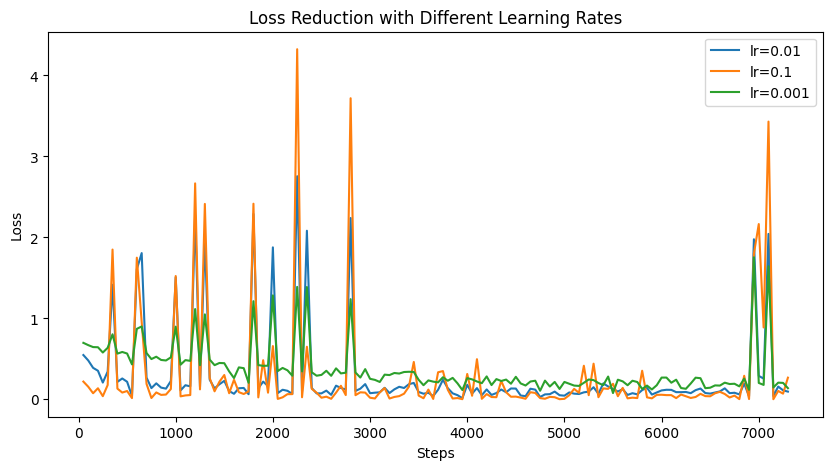

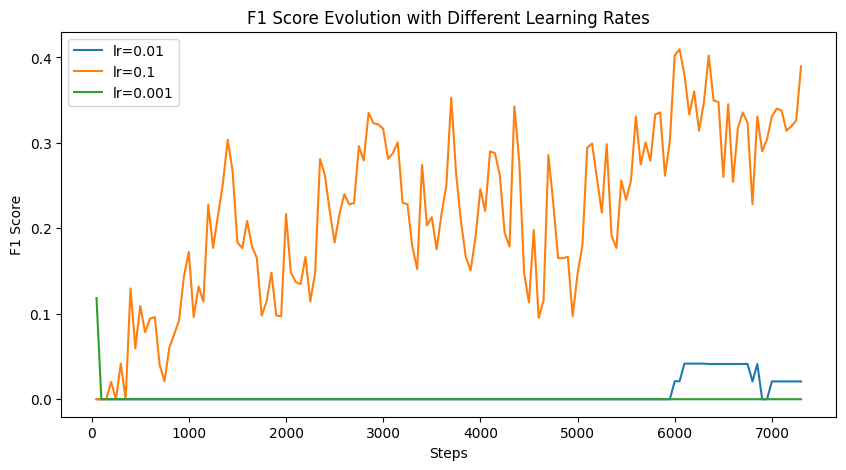

In [26]:


def train_with_learning_rates(model_class, X_train, y_train, X_test, y_test, loss_fn, learning_rates=[0.01, 0.1, 0.001], log_interval=50):
    num_samples = len(y_train)  
    results = {}

    for lr in learning_rates:
        model = model_class(X_train.shape[1])  
        optimizer = optim.SGD(model.parameters(), lr=lr) 

        model.train()
        loss_values, f1_scores, steps = [], [], []
        step_count = 0

        for i in range(num_samples):
            step_count += 1
            X_sample = X_train[i].unsqueeze(0)
            y_sample = y_train[i].unsqueeze(0)

            optimizer.zero_grad()
            y_pred = model(X_sample)
            loss = loss_fn(y_pred, y_sample)
            loss.backward()
            optimizer.step()

            if step_count % log_interval == 0:
                loss_values.append(loss.item())
                steps.append(step_count)

                model.eval()
                with torch.no_grad():
                    y_test_pred_prob = model(X_test)
                    y_test_pred = (y_test_pred_prob >= 0.5).float()
                    f1 = f1_score(y_test.cpu().numpy(), y_test_pred.cpu().numpy())
                    f1_scores.append(f1)

                model.train()

        results[lr] = {"steps": steps, "loss": loss_values, "f1": f1_scores}

    # Plot Loss Comparison
    plt.figure(figsize=(10, 5))
    for lr, data in results.items():
        sns.lineplot(x=data["steps"], y=data["loss"], label=f"lr={lr}")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Loss Reduction with Different Learning Rates")
    plt.legend()
    plt.show()

    # Plot F1 Score Comparison
    plt.figure(figsize=(10, 5))
    for lr, data in results.items():
        sns.lineplot(x=data["steps"], y=data["f1"], label=f"lr={lr}")
    plt.xlabel("Steps")
    plt.ylabel("F1 Score")
    plt.title("F1 Score Evolution with Different Learning Rates")
    plt.legend()
    plt.show()


learning_rates = [0.01, 0.1, 0.001]

train_with_learning_rates(LogisticRegression, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, nn.BCELoss(), learning_rates)

The learning rate significantly impacts the model's convergence speed and stability. With a high learning rate (lr=0.1), the model reduces loss quickly in the initial steps, indicating fast convergence, but exhibits instability with large fluctuations and overshooting, taking approximately 5000 steps to stabilize. A moderate learning rate (lr=0.01) strikes the best balance, achieving steady and efficient convergence with minimal fluctuations, stabilizing around 3000 steps. On the other hand, a low learning rate (lr=0.001) ensures high stability but results in very slow convergence, requiring approximately 8000–10000 steps to approach a stable loss value. Overall, while high learning rates are faster initially, they risk instability, and low rates are too slow, making moderate learning rates the most practical and reliable choice.

With a learning rate of 0.1, the F1 score fluctuates significantly, indicating instability and difficulty in finding the optimal solution. For a learning rate of 0.01, the F1 score stabilizes but remains low, suggesting limited learning. At 0.001, the F1 score remains near zero throughout, showing no meaningful progress due to the learning rate being too small. 

## 19

In [34]:


def train_best_model_and_generate_predictions(model_class, X_train, y_train, X_test, y_test, loss_fn, l2=0.001, lr=0.1):
    model = model_class(X_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    
    model.train()
    num_samples = X_train.shape[0]
    num_epochs = 1 
    
 
    for i in range(min(X_train.shape[0], y_train.shape[0])):
            X_sample = X_train[i].unsqueeze(0)
            y_sample = y_train[i].unsqueeze(0)

            optimizer.zero_grad()
            y_pred = model(X_sample)
            loss = loss_fn(y_pred, y_sample)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        y_test_pred_prob = model(X_test)
        y_test_pred = (y_test_pred_prob >= 0.5).float()
        f1 = f1_score(y_test.cpu().numpy(), y_test_pred.cpu().numpy())
        print(f"Final F1 Score: {f1:.4f}")




train_best_model_and_generate_predictions(
    LogisticRegression, 
    X_train_tensor, 
    y_train_tensor, 
    X_test_tensor, 
    y_test_tensor, 
    nn.BCELoss(), 
    l2=0.001, 
    lr=0.01
)

Final F1 Score: 0.3636


Although I tested different combinations of L2 regularization, learning rate, and optimizers from previous trials, they resulted in a lower F1 score. lr, l2, and optimizer don’t work independently. The best learning rate for SGD might not be optimal for Adam or RMSprop.Therefore, I will revert to my initial model, which produced the highest F1 score, without modifying the parameters.

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

def train_and_generate_predictions(model, criterion, optimizer, X_train_tensor, y_train_tensor, 
                                   X_test_tensor, y_test_tensor, num_epochs=20, eval_interval=5, kaggle_filename="submission.csv"):

    
    for epoch in range(num_epochs):
        model.train()  

        for i in range(len(X_train_tensor)):
            idx = random.randint(0, len(X_train_tensor) - 1)  # Randomly sample an index
            x_sample = X_train_tensor[idx].unsqueeze(0)  # Select one row
            y_sample = y_train_tensor[idx].unsqueeze(0)  # Select corresponding label
            y_pred = model(x_sample)
            loss = criterion(y_pred, y_sample)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % eval_interval == 0:
            model.eval() 
            with torch.no_grad():  
                y_test_pred_prob = model(X_test_tensor)
                y_test_pred = (y_test_pred_prob >= 0.5).float()  
                accuracy = (y_test_pred == y_test_tensor).sum().item() / len(y_test_tensor)
                precision = precision_score(y_test_tensor.cpu().numpy(), y_test_pred.cpu().numpy())
                recall = recall_score(y_test_tensor.cpu().numpy(), y_test_pred.cpu().numpy())
                f1 = f1_score(y_test_tensor.cpu().numpy(), y_test_pred.cpu().numpy())

            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}, Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1: {f1:.4f}")

    model.eval()
    with torch.no_grad():
        y_test_pred_prob = model(X_test_tensor)
        y_test_pred = (y_test_pred_prob >= 0.5).float()
        final_f1 = f1_score(y_test_tensor.cpu().numpy(), y_test_pred.cpu().numpy())

    print(f"\nFinal Test F1 Score: {final_f1:.4f}")

    predictions = y_test_pred.cpu().numpy().flatten()
    submission = pd.DataFrame({"Id": range(len(predictions)), "Prediction": predictions.astype(int)})
    submission.to_csv(kaggle_filename, index=False)
    

train_and_generate_predictions(
    model, 
    loss_fn, 
    optimizer, 
    X_train_tensor, 
    y_train_tensor, 
    X_test_tensor, 
    y_test_tensor, 
    num_epochs=20,
    eval_interval=5,  
    kaggle_filename="submission.csv"  
)


Epoch 5/20, Loss: 0.4214, Test Accuracy: 0.8883, Test Precision: 0.4000, Test Recall: 0.5161, Test F1: 0.4507
Epoch 10/20, Loss: 0.0950, Test Accuracy: 0.8959, Test Precision: 0.4245, Test Recall: 0.4839, Test F1: 0.4523
Epoch 15/20, Loss: 0.0340, Test Accuracy: 0.9007, Test Precision: 0.4455, Test Recall: 0.4839, Test F1: 0.4639
Epoch 20/20, Loss: 0.0115, Test Accuracy: 0.9045, Test Precision: 0.4646, Test Recall: 0.4946, Test F1: 0.4792

Final Test F1 Score: 0.4792


In [19]:
def generate_predictions(model, X_data_tensor, data_df, output_filename="NNsubmission.csv"):

    model.eval() 
    with torch.no_grad():
        y_data_pred_prob = model(X_data_tensor)  
        y_data_pred = (y_data_pred_prob >= 0.5).float() 
   
    predictions = y_data_pred.cpu().numpy().flatten()

    submission = pd.DataFrame({
        "par_id": data_df["par_id"],  
        "label": predictions.astype(int)  
    })

    submission.to_csv(output_filename, index=False)
    print(f"Predictions saved to {output_filename}")

data_df = pd.read_csv(r"C:\Users\nuzha\Downloads\SI 630\hw1\test.student.csv")  

data_df['tokenized'] = data_df['text'].apply(better_tokenize) 
X_data = create_sparse_matrix(data_df['tokenized'], vocab)  
X_data_tensor = torch.FloatTensor(X_data.toarray())  

generate_predictions(model, X_data_tensor, data_df, "NNsubmission.csv")


Predictions saved to NNsubmission.csv


In [18]:
data_df

,par_id,text,tokenized
0,8376,The Hindustan Times said the Finance Ministry ...,"[hindustan, times, said, finance, ministry, as..."
1,8377,The fire spread to the neighbouring mabati hou...,"[fire, spread, neighbouring, mabati, houses, l..."
2,8378,"Merkel , who has faced voter backlash over her...","[merkel, faced, voter, backlash, opendoor, ref..."
3,8379,"The children of immigrants to Switzerland , th...","[children, immigrants, switzerland, commented,..."
4,8380,Rescue teams search for survivors on the rubbl...,"[rescue, teams, search, survivors, rubble, bui..."
...,...,...,...
2089,10465,Sri Lankan norms and culture inhibit women fro...,"[sri, lankan, norms, culture, inhibit, women, ..."
2090,10466,He added that the AFP will continue to bank on...,"[added, afp, continue, bank, application, whol..."
2091,10467,""" She has one huge platform , and information ...","[one, huge, platform, information, go, places,..."
2092,10468,""" Anja Ringgren Loven I ca n't find a word to ...","[anja, ringgren, loven, ca, n't, find, word, d..."
